In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
df = pd.read_parquet("test_data.parquet")

df.describe(include="all")

,match_id,event_idx,dribble_outcome,shot_first_time,foul_committed_offensive,team_id,substitution_replacement_id,possession_team,foul_committed_card,pass_length,...,ball_receipt_outcome,goalkeeper_technique,related_events,goalkeeper_end_location,under_pressure,pass_no_touch,clearance_left_foot,shot_saved_to_post,block_offensive,shot_shot_shot_assist
count,7.417800e+05,741780.000000,5740,2124,240,741780.000000,2158.000000,741780,769,208113.000000,...,24954,2030,703702,4211,165943,234,2101,23,243,37
unique,NaN,NaN,2,1,1,NaN,NaN,16,3,NaN,...,1,2,676618,2221,1,1,1,1,1,1
top,NaN,NaN,Incomplete,True,True,NaN,NaN,Team 13,Yellow Card,NaN,...,Incomplete,Standing,"[""f885377d-8b13-4188-ba77-73c5de72cc21""]","[1.2, 39.8]",True,True,True,True,True,True
freq,NaN,NaN,2918,2124,240,NaN,NaN,55019,712,NaN,...,24954,1755,4,12,165943,234,2101,23,243,37
mean,3.941482e+06,1560.807908,NaN,NaN,NaN,1565.511936,169565.879055,NaN,NaN,22.380773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.901169e+01,912.407918,NaN,NaN,NaN,1294.350521,164250.237175,NaN,NaN,15.203447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.941362e+06,0.000000,NaN,NaN,NaN,323.000000,4809.000000,NaN,NaN,-0.697202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.941423e+06,775.000000,NaN,NaN,NaN,1028.000000,31207.000000,NaN,NaN,11.647182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.941482e+06,1551.000000,NaN,NaN,NaN,1281.000000,65017.000000,NaN,NaN,18.497486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.941542e+06,2327.000000,NaN,NaN,NaN,1292.000000,366338.000000,NaN,NaN,28.855232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
print("Rows:", df.shape[0])
print("Cols:", df.shape[1])

df.info()

Rows: 741780
Cols: 131
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741780 entries, 0 to 741779
Columns: 131 entries, match_id to shot_shot_shot_assist
dtypes: float64(23), int64(9), object(99)
memory usage: 741.4+ MB


In [37]:
summary = (
    df
    .dtypes
    .to_frame("dtype")
    .assign(
        missing=df.isna().sum(),
        missing_pct=df.isna().mean() * 100,
        unique=df.nunique()
    )
    .sort_values("missing_pct", ascending=False)
)

summary


,dtype,missing,missing_pct,unique
shot_follows_dribble,object,741779,99.999865,1
goalkeeper_lost_in_play,object,741777,99.999596,1
goalkeeper_success_in_play,object,741776,99.999461,1
shot_redirect,object,741772,99.998922,1
shot_shot_goal_assist,object,741764,99.997843,1
...,...,...,...,...
period,int64,0,0.000000,2
id,object,0,0.000000,741780
team,object,0,0.000000,16
play_pattern,object,0,0.000000,9


In [38]:
", ".join(df.columns)

'match_id, event_idx, dribble_outcome, shot_first_time, foul_committed_offensive, team_id, substitution_replacement_id, possession_team, foul_committed_card, pass_length, shot_gk_save_difficulty_xg, block_deflection, dribble_no_touch, goalkeeper_punched_out, ball_recovery_recovery_failure, obv_total_net, pass_through_ball, obv_against_net, duel_outcome, goalkeeper_success_in_play, pass_outswinging, out, ball_recovery_offensive, shot_aerial_won, shot_statsbomb_xg, pass_cut_back, shot_follows_dribble, substitution_outcome, clearance_body_part, pass_pass_cluster_label, shot_shot_execution_xg_uplift, clearance_right_foot, shot_redirect, goalkeeper_shot_saved_to_post, shot_body_part, obv_against_before, pass_goal_assist, pass_shot_assist, duel_type, foul_won_advantage, index, substitution_replacement, pass_recipient_id, shot_gk_positioning_xg_suppression, block_save_block, goalkeeper_shot_saved_off_target, goalkeeper_lost_in_play, player, minute, interception_outcome, shot_end_location, pas

<Axes: >

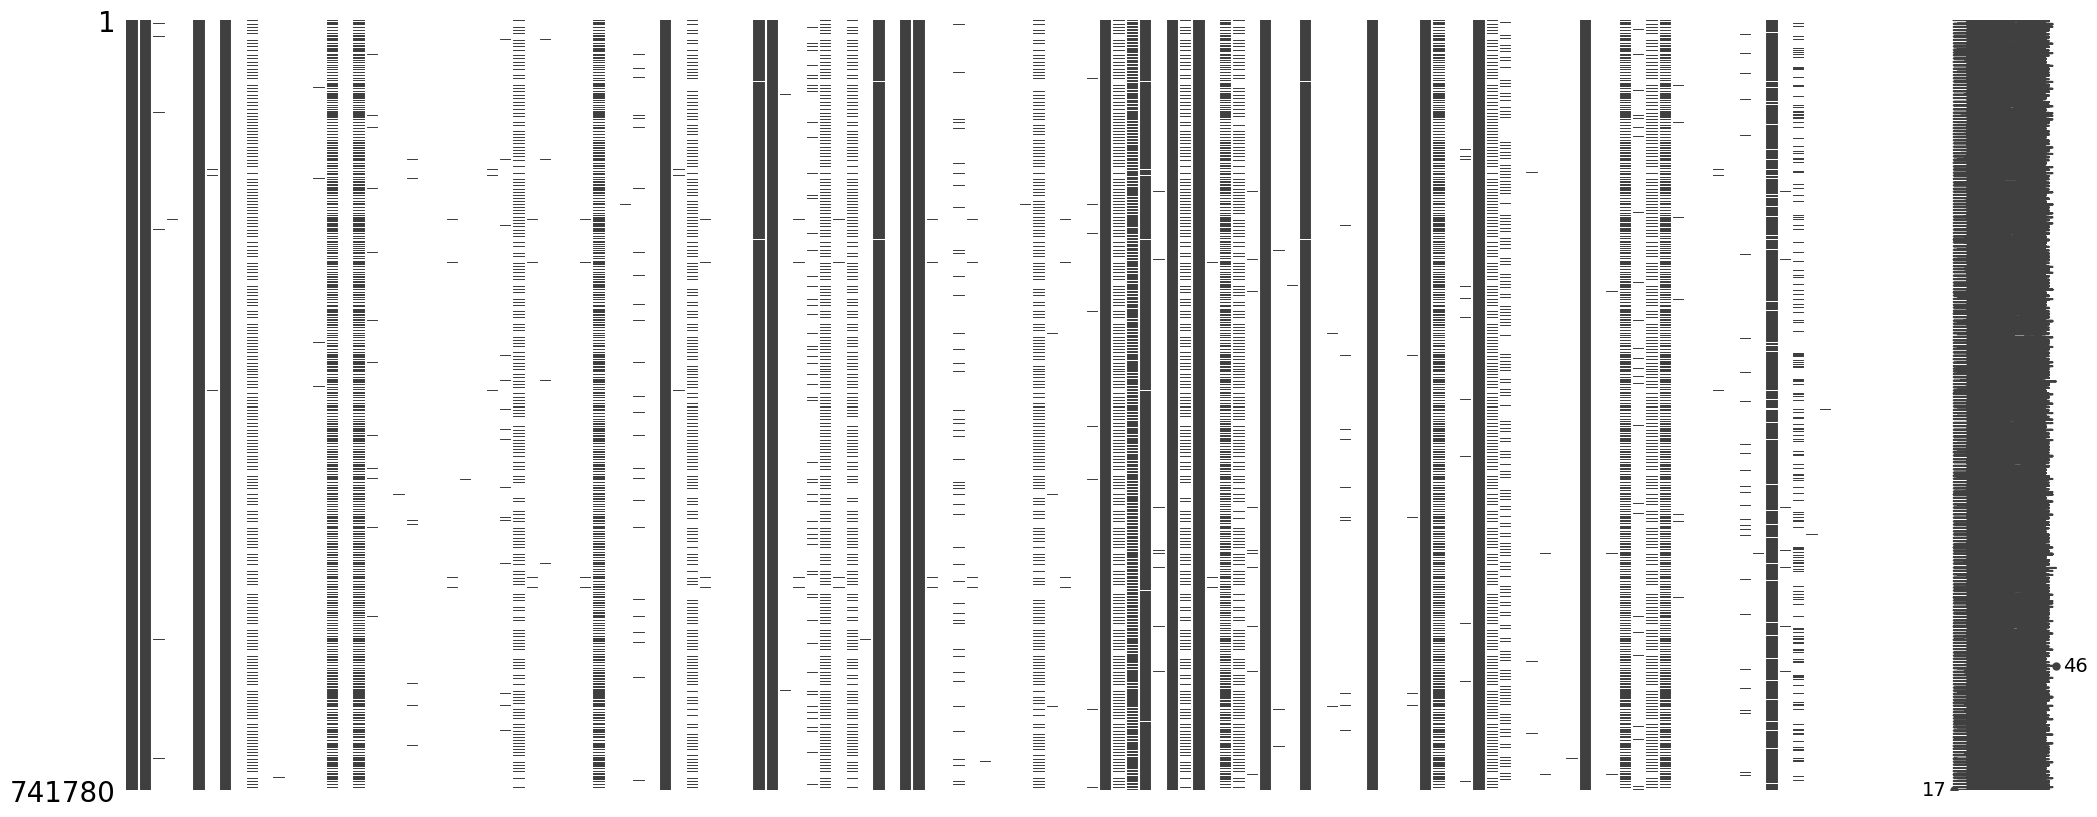

In [39]:
msno.matrix(df)

In [40]:
def n_unique(col):
    return df[col].nunique(dropna=True) if col in df.columns else None

summary_counts = {
    "matches": n_unique("match_id"),
    "teams": n_unique("team_id") or n_unique("team"),
    "players": n_unique("player_id") or n_unique("player"),
    "possessions": n_unique("possession"),
}
summary_counts


{'matches': 239, 'teams': 16, 'players': 483, 'possessions': 216}

In [41]:
event_type_col = "type"
# někdy je type jako dict/objekt; když je to string, jede přímo
df[event_type_col].value_counts(dropna=False).head(30)


type
Pass                 208113
Ball Receipt*        179286
Carry                153890
Pressure              73452
Ball Recovery         24331
Duel                  17701
Clearance             11920
Block                 10863
Goal Keeper            8015
Miscontrol             6923
Foul Committed         6442
Shot                   6218
Foul Won               6168
Dribble                5740
Dispossessed           5063
Interception           3763
Dribbled Past          3137
Substitution           2158
50/50                  1660
Injury Stoppage        1449
Half Start              956
Half End                956
Tactical Shift          865
Referee Ball-Drop       597
Shield                  486
Starting XI             478
Player Off              344
Player On               342
Bad Behaviour           199
Error                   157
Name: count, dtype: int64

In [42]:
if "minute" in df.columns and "second" in df.columns:
    print("Minute range:", df["minute"].min(), "→", df["minute"].max())
    print("Second range:", df["second"].min(), "→", df["second"].max())

if "period" in df.columns:
    print("Periods:", sorted(df["period"].dropna().unique()))


Minute range: 0 → 102
Second range: 0 → 59
Periods: [np.int64(1), np.int64(2)]


In [43]:
if "player" in df.columns:
    display(df["player"].value_counts().head(15))

if "team" in df.columns:
    display(df["team"].value_counts().head(15))


player
Player 408    5264
Player 317    5025
Player 102    4979
Player 438    4953
Player 204    4909
Player 242    4841
Player 466    4825
Player 434    4811
Player 371    4548
Player 132    4513
Player 446    4489
Player 221    4411
Player 222    4350
Player 161    4333
Player 205    4274
Name: count, dtype: int64

team
Team 13    53197
Team 10    52661
Team 15    51555
Team 1     50998
Team 8     49990
Team 7     47260
Team 4     46568
Team 9     44983
Team 5     44853
Team 12    44669
Team 14    44058
Team 6     43915
Team 11    43020
Team 2     42980
Team 3     40664
Name: count, dtype: int64

In [44]:
core_events = [
    "Pass",
    "Carry",
    "Shot",
    "Dribble",
    "Duel",
    "Interception",
    "Ball Recovery",
    "Pressure"
]

df_core = df[df["type"].isin(core_events)].copy()
df_core.shape


(493208, 131)

In [45]:
player_events = (
    df_core
    .groupby("player")
    .agg(
        events=("type", "count"),
        passes=("type", lambda x: (x == "Pass").sum()),
        shots=("type", lambda x: (x == "Shot").sum()),
        dribbles=("type", lambda x: (x == "Dribble").sum()),
    )
    .sort_values("events", ascending=False)
)

player_events.head(10)


,events,passes,shots,dribbles
player,,,,
Player 408,3641,1789,30,18
Player 317,3534,1466,29,33
Player 438,3468,1457,55,32
Player 204,3435,1456,26,21
Player 102,3430,1687,9,18
Player 242,3384,1657,33,18
Player 466,3355,1636,11,15
Player 434,3166,1168,93,73
Player 446,3147,1462,31,35


In [46]:
player_value = (
    df
    .groupby("player")
    .agg(
        xg=("shot_statsbomb_xg", "sum"),
        obv_for=("obv_for_net", "sum"),
        obv_against=("obv_against_net", "sum"),
        events=("type", "count")
    )
)

player_value["obv_net"] = (
    player_value["obv_for"].fillna(0)
    - player_value["obv_against"].fillna(0)
)

player_value.sort_values("obv_net", ascending=False).head(10)


,xg,obv_for,obv_against,events,obv_net
player,,,,,
Player 12,0.000000,3.789625,-8.770463,2812,12.560088
Player 209,0.662942,8.311700,-3.427151,3593,11.738850
Player 205,0.546157,7.086047,-4.330227,4274,11.416274
Player 181,0.698198,9.976263,-1.278211,2805,11.254474
Player 242,2.254417,8.824453,-2.081506,4841,10.905959
Player 294,0.000000,3.208306,-7.459947,2838,10.668253
Player 63,2.675763,9.838133,-0.421802,4102,10.259934
Player 117,9.537003,9.182991,-0.672746,3596,9.855737
Player 446,1.341356,7.505127,-1.897688,4489,9.402815


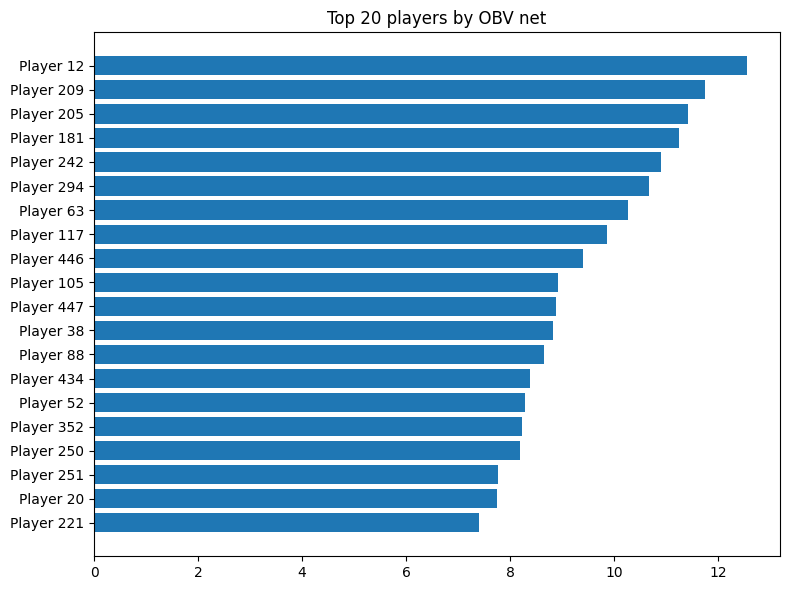

In [47]:
top = player_value.sort_values("obv_net", ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.barh(top.index, top["obv_net"])
plt.title("Top 20 players by OBV net")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [48]:
player_minutes = (
    df.groupby(["match_id", "player"])
    .agg(
        min_minute=("minute", "min"),
        max_minute=("minute", "max")
    )
    .assign(minutes=lambda x: x["max_minute"] - x["min_minute"])
    .reset_index()
)

player_minutes["minutes"] = player_minutes["minutes"].clip(lower=1)


In [49]:
minutes_total = (
    player_minutes
    .groupby("player")["minutes"]
    .sum()
    .rename("minutes_played")
)


In [50]:
progression = (
    df.groupby("player")
    .agg(
        obv_for=("obv_for_net", "sum"),
        obv_against=("obv_against_net", "sum")
    )
)

progression["progression_raw"] = (
    progression["obv_for"].fillna(0)
    - progression["obv_against"].fillna(0)
)


In [51]:
threat = (
    df.groupby("player")
    .agg(
        xg=("shot_statsbomb_xg", "sum")
    )
)


In [52]:
creation = (
    df.groupby("player")
    .agg(
        shot_assists=("pass_shot_assist", "sum"),
        goal_assists=("pass_goal_assist", "sum")
    )
)

creation = creation.fillna(0)


In [53]:
defense = (
    df.groupby("player")
    .agg(
        defensive_obv=("obv_against_net", "sum"),
        interceptions=("type", lambda x: (x == "Interception").sum()),
        recoveries=("type", lambda x: (x == "Ball Recovery").sum())
    )
)

defense["defensive_raw"] = (
    defense["interceptions"]
    + defense["recoveries"]
    - defense["defensive_obv"].fillna(0)
)


In [54]:
player_base = (
    minutes_total
    .to_frame()
    .join([progression, threat, creation, defense])
    .fillna(0)
)

player_base.head()


,minutes_played,obv_for,obv_against,progression_raw,xg,shot_assists,goal_assists,defensive_obv,interceptions,recoveries,defensive_raw
player,,,,,,,,,,,
Player 1,1539,0.608791,-0.710511,1.319301,7.289326,12,0,-0.710511,8,74,82.710511
Player 10,1308,2.734372,-0.190415,2.924787,0.716686,11,0,-0.190415,10,62,72.190415
Player 100,377,0.095332,-0.179440,0.274772,0.064145,True,0,-0.179440,12,24,36.179440
Player 101,196,0.574208,-0.021084,0.595292,0.133297,8,0,-0.021084,2,17,19.021084
Player 102,2532,2.011433,-1.058928,3.070362,2.312702,9,0,-1.058928,19,120,140.058928


In [55]:
for col in [
    "progression_raw",
    "xg",
    "shot_assists",
    "goal_assists",
    "defensive_raw"
]:
    player_base[f"{col}_per90"] = (
        player_base[col] / player_base["minutes_played"] * 90
    )


In [56]:
player_base_filt = player_base[player_base["minutes_played"] >= 450].copy()

player_base_filt.shape


(321, 16)

In [60]:
features = [
    "progression_raw_per90",
    "xg_per90",
    "shot_assists_per90",
    "goal_assists_per90",
    "defensive_raw_per90"
]

scaler = StandardScaler()

player_base_filt[[f"{f}_z" for f in features]] = scaler.fit_transform(
    player_base_filt[features]
)


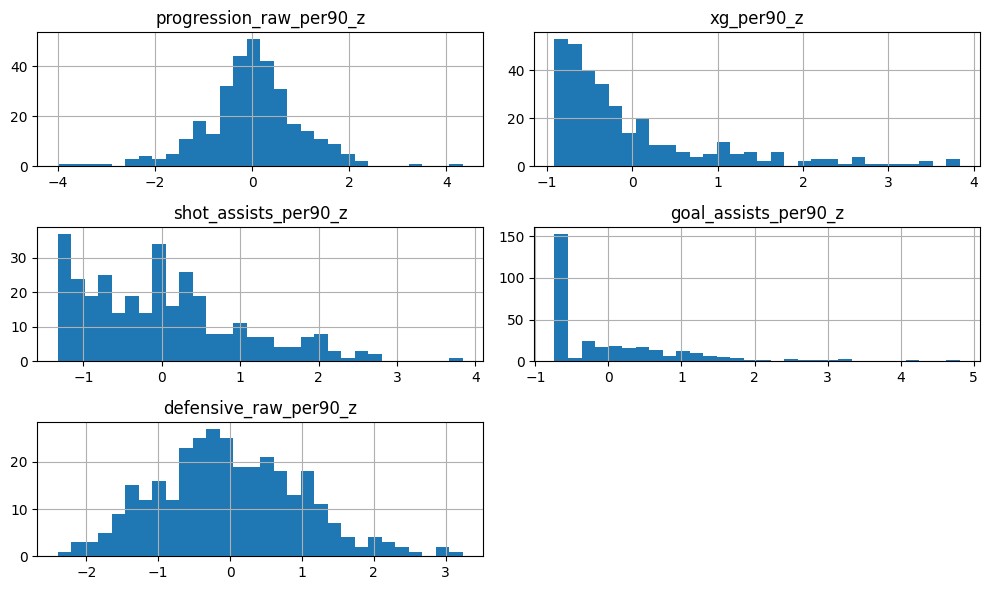

In [ ]:
player_base_filt[[f"{f}_z" for f in features]].hist(
    figsize=(10, 6),
    bins=30
)
plt.tight_layout()
plt.show()


In [64]:
player_base_filt["GPIS"] = (
    0.30 * player_base_filt["progression_raw_per90_z"]
  + 0.20 * player_base_filt["xg_per90_z"]
  + 0.20 * player_base_filt["shot_assists_per90_z"]
  + 0.10 * player_base_filt["goal_assists_per90_z"]
  + 0.20 * player_base_filt["defensive_raw_per90_z"]
)


In [65]:
rating = (
    player_base_filt
    .sort_values("GPIS", ascending=False)
    .reset_index()
)

rating[["player", "minutes_played", "GPIS"]].head(10)


,player,minutes_played,GPIS
0,Player 117,1902,1.764075
1,Player 302,482,1.584742
2,Player 447,1909,1.508747
3,Player 20,1499,1.452298
4,Player 250,2007,1.322767
5,Player 388,621,1.256489
6,Player 242,2486,1.240672
7,Player 389,608,1.189610
8,Player 181,1910,1.187365
9,Player 434,2560,1.156766


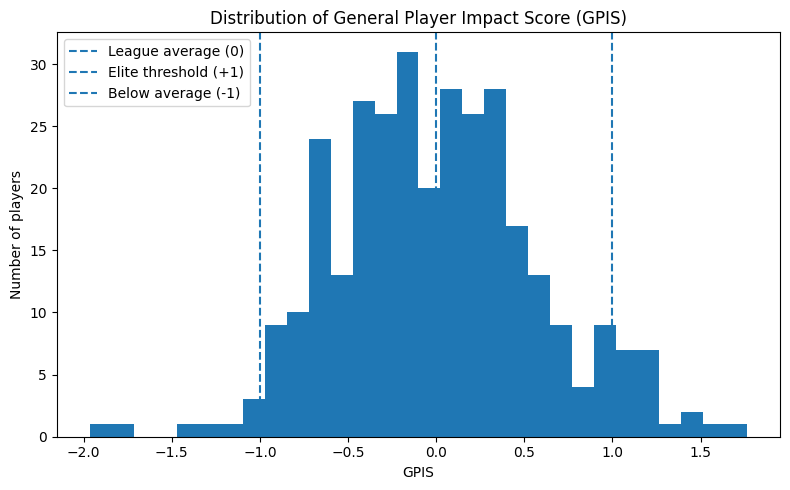

In [66]:
plt.figure(figsize=(8, 5))
plt.hist(player_base_filt["GPIS"], bins=30)
plt.axvline(0, linestyle="--", label="League average (0)")
plt.axvline(1, linestyle="--", label="Elite threshold (+1)")
plt.axvline(-1, linestyle="--", label="Below average (-1)")

plt.title("Distribution of General Player Impact Score (GPIS)")
plt.xlabel("GPIS")
plt.ylabel("Number of players")
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
similarity_features = [
    "progression_raw_per90_z",
    "xg_per90_z",
    "shot_assists_per90_z",
    "goal_assists_per90_z",
    "defensive_raw_per90_z"
]

In [68]:
X = player_base_filt[similarity_features]


In [72]:
similarity_matrix = cosine_similarity(X)

In [73]:
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=X.index,
    columns=X.index
)

In [74]:
def find_similar_players(
    player_name,
    similarity_df,
    player_stats,
    top_n=10,
    min_minutes=450
):
    if player_name not in similarity_df.index:
        raise ValueError("Player not found")

    sims = (
        similarity_df[player_name]
        .drop(player_name)
        .sort_values(ascending=False)
        .head(top_n)
    )

    result = (
        sims
        .to_frame("similarity")
        .join(player_stats[["GPIS", "minutes_played"]])
    )

    return result


In [75]:
top_player = rating.iloc[0]["player"]
top_player

'Player 117'

In [76]:
find_similar_players(
    player_name=top_player,
    similarity_df=similarity_df,
    player_stats=player_base_filt,
    top_n=10
)

,similarity,GPIS,minutes_played
player,,,
Player 37,0.942493,0.824143,802
Player 20,0.939593,1.452298,1499
Player 312,0.937121,1.052247,1669
Player 447,0.901286,1.508747,1909
Player 237,0.890287,0.904572,1191
Player 434,0.878392,1.156766,2560
Player 116,0.859711,1.067977,979
Player 371,0.839026,1.030848,2646
Player 11,0.832079,0.695418,2058
